In [6]:
import os, sys, json, random
import pandas as pd
import numpy as np
!{sys.executable} -m pip install networkx
import networkx as nx
from sklearn.base import BaseEstimator

from util.d3mds import D3MDataset, D3MProblem, D3MDS

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
# doesn't detect __file__ in interactive shell
# here = os.path.dirname(os.path.abspath(__file__))
# instead, use '__file__'?! (this is bizzare).
here = os.path.dirname(os.path.abspath('__file__'))

dspath = os.path.join(here, 'data', 'uu3_world_development_indicators', 
                      'uu3_world_development_indicators_dataset')
prpath = os.path.join(here, 'data', 'uu3_world_development_indicators', 
                      'uu3_world_development_indicators_problem')
solpath = os.path.join(here, 'log_d3m')
assert os.path.exists(dspath)
assert os.path.exists(prpath)

d3mds = D3MDS(dspath, prpath) # this checks that the problem and dataset correspond

## Load Data

In [155]:
trainData = d3mds.get_train_data()
print(trainData.shape)

trainTargets = d3mds.get_train_targets()
print(trainTargets.shape)

testData = d3mds.get_test_data()
print(testData.shape)

testTargets = d3mds.get_test_targets()
print(testTargets.shape)

(9843, 5)
(9843, 1)
(2461, 5)
(2461, 1)


## Exploratory Data Analysis

Index(['CountryName', 'CountryCode', 'IndicatorName', 'IndicatorCode', 'Year'], dtype='object')
['Life expectancy at birth, total (years)'] ['SP.DYN.LE00.IN']

54 54
set()
240 240
0


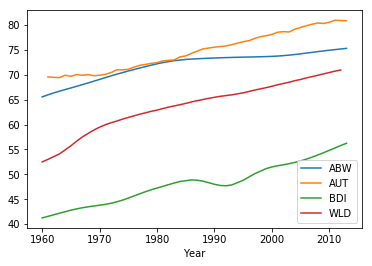

In [161]:
print(trainData.columns)
print(np.unique(trainData['IndicatorName']), np.unique(trainData['IndicatorCode']))

print()

# temporal (time-series) regression
df = trainData.copy()
df['Value'] = trainTargets
df = df.drop(['IndicatorName','IndicatorCode','CountryName'],axis=1)
df = df[(df['CountryCode'] == 'ABW') | (df['CountryCode'] == 'BDI')
        | (df['CountryCode'] == 'AUT') | (df['CountryCode'] == 'WLD') ]

df.set_index('Year', inplace=True)
df.groupby('CountryCode')['Value'].plot(legend=True)


# Train and test data both span over the same years
print(len(np.unique(testData['Year'])), len(np.unique(trainData['Year'])))
print(set(np.unique(testData['Year']))-set(np.unique(trainData['Year'])))

# Test data contains the same set of CountryCode
print(len(np.unique(trainData['CountryCode'])), len(np.unique(trainData['CountryCode'])))
diff_code = set(np.unique(testData['CountryCode'])) - set(np.unique(trainData['CountryCode']))
print(len(diff_code))

## Build Model

### Data Processing

In [183]:
# Probably one-hot-encode CountryCode
# Remove CountryName, IndicatorName, IndicatorCode

train_df = trainData.copy()
train_df = train_df.drop(['IndicatorName','IndicatorCode','CountryName'],axis=1)

test_df = testData.copy()
test_df = test_df.drop(['IndicatorName','IndicatorCode','CountryName'],axis=1)

# Must keep d3m_index for successful recovery
all_df = pd.concat([train_df, test_df], axis=0)
all_df = pd.get_dummies(all_df, columns=['CountryCode'])
train_df = all_df.iloc[:len(train_df),:]
test_df = all_df.iloc[len(train_df):,:]

assert len(set(testData.index) - set(test_df.index)) == 0

scaler = MinMaxScaler()
train_df['Year'] = scaler.fit_transform(train_df['Year'].values.reshape(-1,1)).reshape(-1)
test_df['Year'] = scaler.transform(test_df['Year'].values.reshape(-1,1)).reshape(-1)

X_train = train_df.values
X_test = test_df.values

/Users/yeounoh/Virtualenvs/3_5_2/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/yeounoh/Virtualenvs/3_5_2/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/yeounoh/Virtualenvs/3_5_2/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### XGB Regressor

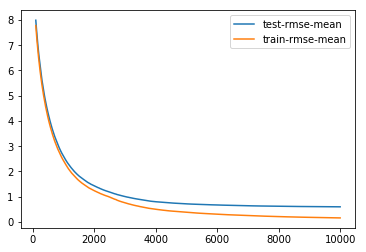

In [190]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=trainTargets)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":3, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=10000, early_stopping_rounds=400)
model.loc[100:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [194]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1)
model_xgb.fit(X_train, trainTargets)
xgb_preds = model_xgb.predict(X_test)

In [195]:
from sklearn.metrics import mean_squared_error
print('xgb regressor RMSE: %s'%np.sqrt(mean_squared_error(testTargets, xgb_preds)))

xgb regressor RMSE: 2.4922107071


### Ridge Regressor

Text(0,0.5,'RMSE')

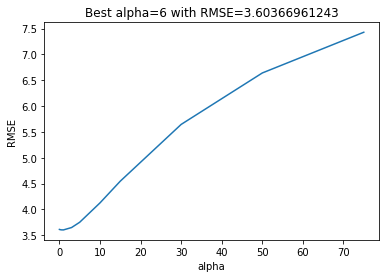

In [201]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, trainTargets, 
                                    scoring='neg_mean_squared_error',
                                   cv=5))
    return rmse

alphas = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 10, 15, 30, 50, 75]

cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Best alpha=%s with RMSE=%s'%
      (cv_ridge.values.argmin(),cv_ridge.values.min()))
plt.xlabel('alpha')
plt.ylabel('RMSE')

In [202]:
# sanity check with the built-in RidgeCV function
model_ridge = RidgeCV(alphas=alphas).fit(X_train, trainTargets)
rmse_cv(model_ridge).mean()

3.6108502535189722

In [206]:
ridge_preds = model_ridge.predict(X_test)
print('ridge regressor RMSE: %s'%np.sqrt(mean_squared_error(testTargets, ridge_preds)))

ridge regressor RMSE: 3.10687430676


## Bagged Regressor

In [207]:
from sklearn.ensemble import BaggingRegressor

model_bagged = BaggingRegressor(n_estimators=1000)
model_bagged.fit(X_train, trainTargets)
rmse_cv(model_bagged).mean()


/Users/yeounoh/Virtualenvs/3_5_2/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yeounoh/Virtualenvs/3_5_2/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yeounoh/Virtualenvs/3_5_2/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yeounoh/Virtualenvs/3_5_2/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when 

2.5383730389482322

In [208]:
bagged_preds = model_bagged.predict(X_test)
print('bagged regressor RMSE: %s'%np.sqrt(mean_squared_error(testTargets, bagged_preds)))

bagged regressor RMSE: 0.704970776284


## Output Predictions

In [196]:
y_pred = xgb_preds

targetCols = []
targets = d3mds.problem.get_targets()
for target in targets: # could have multiple targets
    targetCols.append(target['colName'])
    
y_pred_df = pd.DataFrame(index=testData.index, data=y_pred, columns=targetCols)
print(y_pred_df)

y_pred_df.to_csv(os.path.join(solpath, 'predictions.csv'))

              Value
d3mIndex           
926       45.853355
1467      57.133793
1689      44.098125
1903      41.491035
3550      35.619755
4126      61.949394
4464      65.527458
4767      48.386612
4868      62.077751
5062      58.420788
9347      57.133793
9857      44.330849
10161     47.752018
12903     67.277229
12993     57.133793
13178     49.759220
13265     51.948471
13437     57.930622
13545     60.228619
13587     57.133793
14123     62.013378
14235     64.924507
14807     46.685081
15166     57.807240
15416     57.133793
15505     52.450336
15985     40.890896
16582     36.460423
17556     55.339363
18407     47.481804
...             ...
5416271   57.850117
5418702   65.649025
5419514   57.078968
5420975   49.362759
5428062   52.460041
5428843   75.619240
5439845   78.863533
5445234   79.671242
5445900   72.104584
5446317   76.127831
5453292   66.567978
5455536   71.817139
5461122   60.433937
5474385   72.765297
5475155   57.438251
5476676   64.297600
5484558   64.877365
